In [115]:
import numpy as np 
import pandas as pd 
import yfinance as yf 

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error 

from keras.models import Sequential
from keras.layers import LSTM, Dense

from datetime import datetime, timedelta

import matplotlib.pyplot as plt 
import seaborn as sns

In [116]:
# stock ticker to visualize
ticker = 'GOOGL'

# fetch last 10 years of close prices with yfinance
startDate = datetime.now() - timedelta(days=365 * 10)
endDate = datetime.now()
prices = yf.download(tickers=ticker, start=startDate, end=endDate)

prices = prices['Close']
print(prices.tail())

[*********************100%%**********************]  1 of 1 completed

Date
2024-01-10    142.279999
2024-01-11    142.080002
2024-01-12    142.649994
2024-01-16    142.490005
2024-01-17    139.690002
Name: Close, dtype: float64


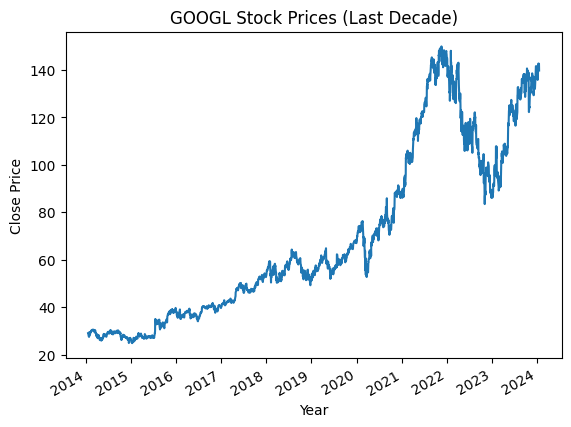

In [117]:
# plot prices in plot
prices.plot(title=f'{ticker} Stock Prices (Last Decade)')
plt.xlabel('Year')
plt.ylabel('Close Price')
plt.show()

In [118]:
# scale date to between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))

prices = prices.values.reshape(-1, 1)
prices = scaler.fit_transform(prices)

# Split Train and Test
The train and test sets will be split into the following:

1. The training set will be the first 7 years.
2. The testing set will be the past 3 years.

In [119]:
# split point is 9 years in or 9/10 of the length, round to the nearest integer
splitPoint = round(0.7 * len(prices))

# differentiate into train and test set
train_set = prices[:splitPoint]
test_set = prices[splitPoint:]

print(len(train_set), len(test_set))

1760 755


In [120]:
# turn arrays of prices into a dataset matrix
def createDataset(dataset, look_back):
	dataX, dataY = [], []
	
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
		
	return np.array(dataX), np.array(dataY)

# create X_train, y_train, X_test, y_test
lookback = 365 # use last year's prices to predict next day's price
X_train, y_train = createDataset(train_set, lookback)
X_test, y_test = createDataset(test_set, lookback)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1394, 365) (1394,)
(389, 365) (389,)


In [121]:
# reshape training sets
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

The model will have 1 layer, 128 LSTM cells and use a sigmoid activation function. The model will be trained with 32 epochs.

Epoch 1/32
7/7 [==============================] - 2s 44ms/step - loss: 0.0713 - val_loss: 0.8816
Epoch 2/32
7/7 [==============================] - 0s 11ms/step - loss: 0.0198 - val_loss: 0.0630
Epoch 3/32
7/7 [==============================] - 0s 11ms/step - loss: 0.0115 - val_loss: 0.1711
Epoch 4/32
7/7 [==============================] - 0s 11ms/step - loss: 0.0073 - val_loss: 0.0207
Epoch 5/32
7/7 [==============================] - 0s 11ms/step - loss: 0.0036 - val_loss: 0.0184
Epoch 6/32
7/7 [==============================] - 0s 13ms/step - loss: 0.0020 - val_loss: 0.0214
Epoch 7/32
7/7 [==============================] - 0s 11ms/step - loss: 0.0015 - val_loss: 0.0234
Epoch 8/32
7/7 [==============================] - 0s 10ms/step - loss: 0.0014 - val_loss: 0.0163
Epoch 9/32
7/7 [==============================] - 0s 11ms/step - loss: 0.0012 - val_loss: 0.0181
Epoch 10/32
7/7 [==============================] - 0s 11ms/step - loss: 0.0012 - val_loss: 0.0148
Epoch 11/32
7/7 [============

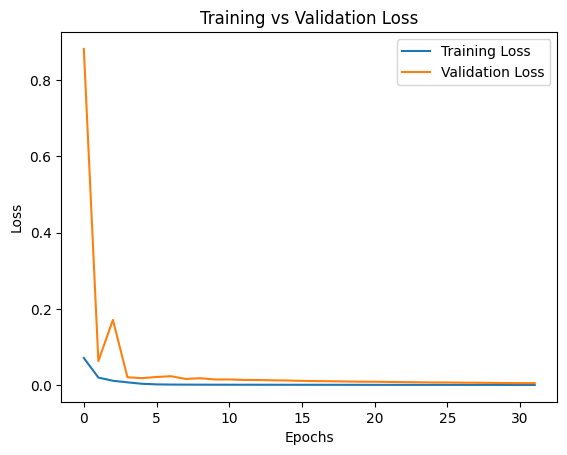

In [122]:
# create LSTM network
model = Sequential()
model.add(LSTM(128, activation='sigmoid', input_shape=(1, X_train.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# fit LSTM network
history = model.fit(X_train, y_train, epochs=32, batch_size=200, verbose=1, validation_data=(X_test, y_test))

# create model train vs validation loss graph to determine overfitting/underfitting
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [123]:
# make predictions for both training and testing data
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

13/13 [==============================] - 0s 2ms/step


Calculate RMSE error

In [124]:
# calculate train score
train_score = np.sqrt(mean_squared_error(y_train, train_predict))
print('Train Score: %.2f RMSE' % (train_score))

# calculate test score
test_score = np.sqrt(mean_squared_error(y_test, test_predict))
print('Test Score: %.2f RMSE' % (test_score))

Train Score: 0.02 RMSE
Test Score: 0.07 RMSE


# Visualize Train and Test Predictions vs Historical Prices

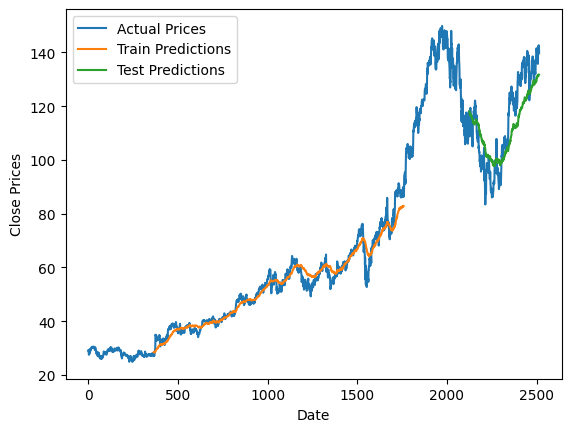

In [125]:
# inverse transform predictions
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

# shift train predictions for plotting
trainPredictPlot = np.empty_like(prices)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[lookback:len(train_predict)+lookback, :] = train_predict

# shift test predictions for plotting
testPredictPlot = np.empty_like(prices)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(lookback*2)+1:len(prices)-1, :] = test_predict

plt.plot(scaler.inverse_transform(prices), label='Actual Prices')
plt.plot(trainPredictPlot, label='Train Predictions')
plt.plot(testPredictPlot, label='Test Predictions')
plt.ylabel('Close Prices')
plt.xlabel('Date')
plt.legend()
plt.show()

# Create Forecast